In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
import swarmbar as sb
import warnings

from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task
from dcmr import decode

res_dir = Path(os.environ['CDCFR_RESULTS'])
fit_dir = Path(os.environ['CDCFR_FITS'])
fig_dir = Path(os.environ['CDCFR_FIGURES']) / 'plots'

data_file = res_dir / 'data.csv'
patterns_file = res_dir / 'patterns.hdf5'
model_dir = fit_dir / 'switchboard' / 'cmrsit_sem-split_cue-focused_dis-cat_sub-list'

fig_dir.mkdir(exist_ok=True, parents=True)
figures.set_style()
%matplotlib inline

In [2]:
data = task.read_study_recall(data_file)
data.head()

,subject,session,list,trial_type,position,item,category,distractor,item_index,block,block_pos,block_len,n_block,curr,prev,next,base
0,201,1,1,study,1,MASCARA,obj,0.0,646,1,1,3,6,obj,<NA>,loc,<NA>
1,201,1,1,study,2,GOLF CLUB,obj,0.0,606,1,2,3,6,obj,<NA>,loc,<NA>
2,201,1,1,study,3,KEYCHAIN,obj,0.0,626,1,3,3,6,obj,<NA>,loc,<NA>
3,201,1,1,study,4,LOS ANGELES,loc,0.0,370,2,1,3,6,loc,obj,cel,cel
4,201,1,1,study,5,GETTYSBURG,loc,0.0,325,2,2,3,6,loc,obj,cel,cel


In [3]:
subj_param = framework.read_fit_param(model_dir / 'fit.csv')
param_def = cmr.read_config(model_dir / 'parameters.json')
patterns = cmr.load_patterns(patterns_file)

In [4]:
subjects = data['subject'].unique()
subj_evidence = []
rng = np.random.default_rng(1)
n_rep = 1
for subject in subjects:
    model = cmr.CMR()
    study = data.query(f'subject == {subject} and trial_type == "study"')
    states = model.record(
        study, 
        {}, 
        subj_param, 
        param_def, 
        patterns, 
        study_keys=['category', 'distractor', 'block_pos'],
    )
    net = states[0]
    l = []
    for i in range(n_rep):
        c = np.vstack([getattr(s, 'c')[net.get_slice('c', 'cat', 'item')] for s in states])
        # c_noise = c + rng.normal(scale=sigma, size=c.shape)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            evidence = decode.classify_patterns(
                study, c, normalization='range', clf='plogreg', C=0.1
            )
        evidence['trial'] = np.arange(evidence.shape[0])
        evidence['rep'] = i
        l.append(evidence)
    evidence = pd.concat(l, axis=0).groupby('trial').mean()
    subj_evidence.append(pd.concat([study.reset_index(), evidence.reset_index()], axis=1).drop(columns='index'))
evidence = pd.concat(subj_evidence, axis=0)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


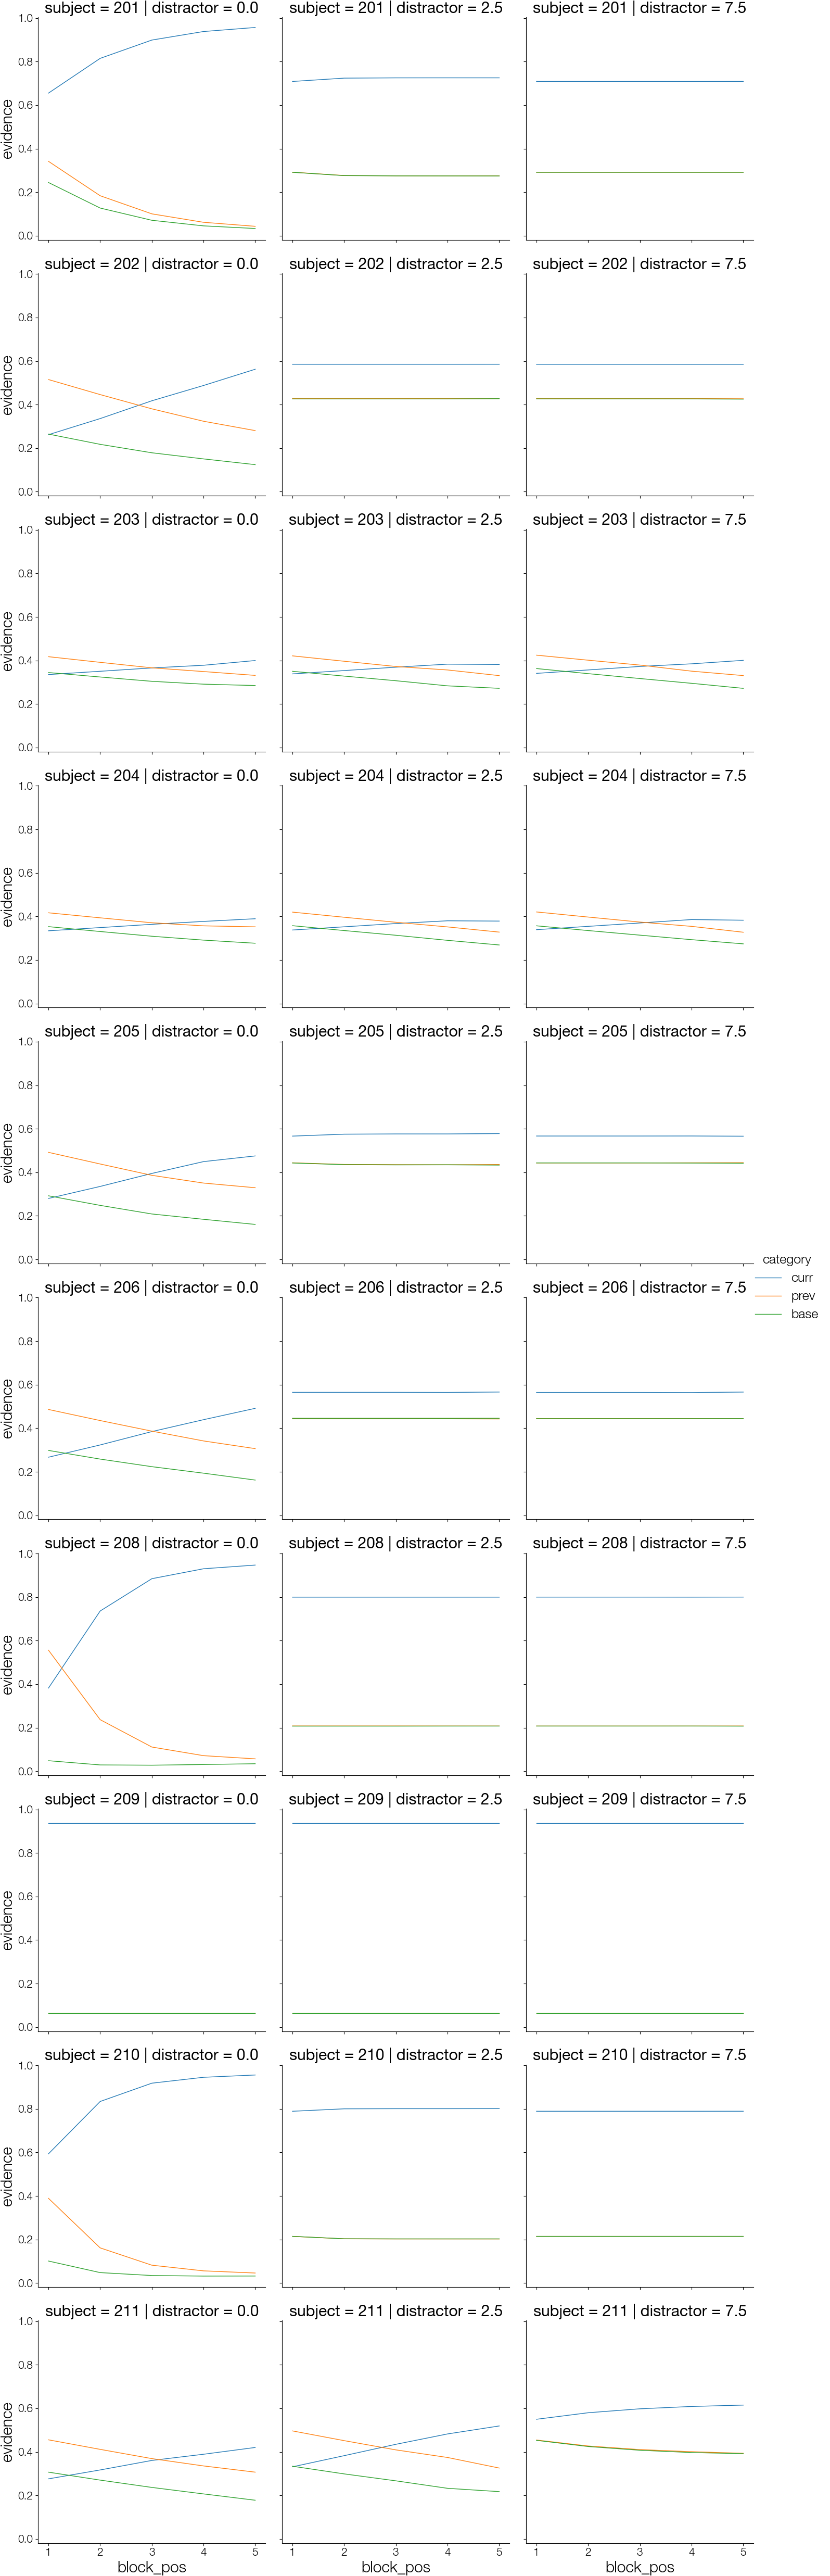

In [5]:
m = evidence.groupby('distractor').apply(decode.evidence_block_pos, include_groups=False)
long = pd.melt(
    m.reset_index(), 
    value_vars=['curr', 'prev', 'base'], 
    id_vars=['subject', 'distractor', 'block_pos'],
    var_name='category',
    value_name='evidence',
)
g = sns.relplot(long, x='block_pos', y='evidence', hue='category', row='subject', col='distractor', kind='line')
g.savefig(fig_dir / 'context_evidence_subj.pdf')

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


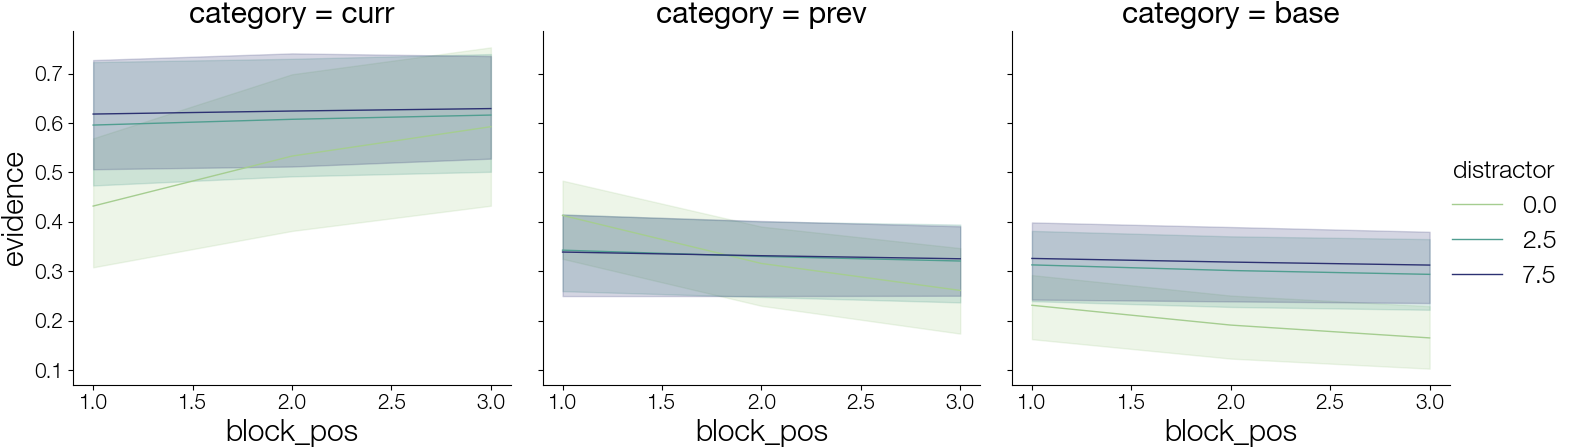

In [6]:
g = sns.relplot(
    long.query('block_pos <= 3'), 
    x='block_pos', 
    y='evidence', 
    hue='distractor', 
    col='category', 
    kind='line',
    palette='crest',
)
g.savefig(fig_dir / 'context_evidence.pdf')

In [7]:
slope = m.groupby('distractor').apply(decode.regress_evidence_block_pos)
sl = pd.melt(
    slope.reset_index(), 
    value_vars=['curr', 'prev', 'base'], 
    id_vars=['subject', 'distractor'],
    var_name='category',
    value_name='slope',
)
sl['Distraction (s)'] = sl['distractor'].astype(float)
sl.head()

,subject,distractor,category,slope,Distraction (s)
0,201,0.0,curr,0.121873,0.0
1,202,0.0,curr,0.077850,0.0
2,203,0.0,curr,0.015244,0.0
3,204,0.0,curr,0.014862,0.0
4,205,0.0,curr,0.057461,0.0


/var/folders/46/7_qmfr6s4ql7l4rb8dkwg_m00000gr/T/ipykernel_89116/1571274377.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


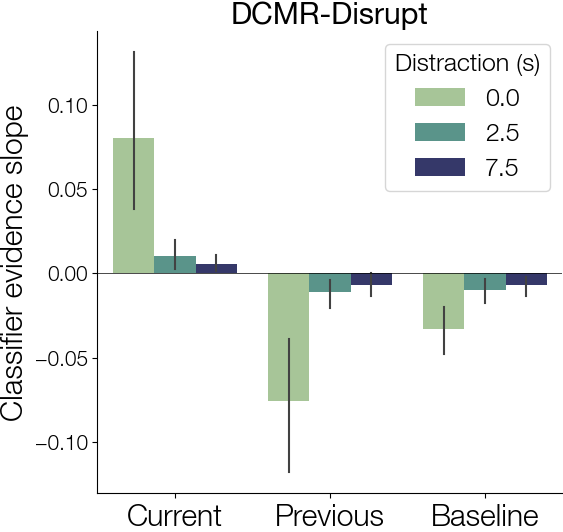

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(sl, x='category', y='slope', hue='Distraction (s)', palette='crest', ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('DCMR-Disrupt')
fig.savefig(fig_dir / 'context_evidence_slope.pdf')

/var/folders/46/7_qmfr6s4ql7l4rb8dkwg_m00000gr/T/ipykernel_89116/53860380.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


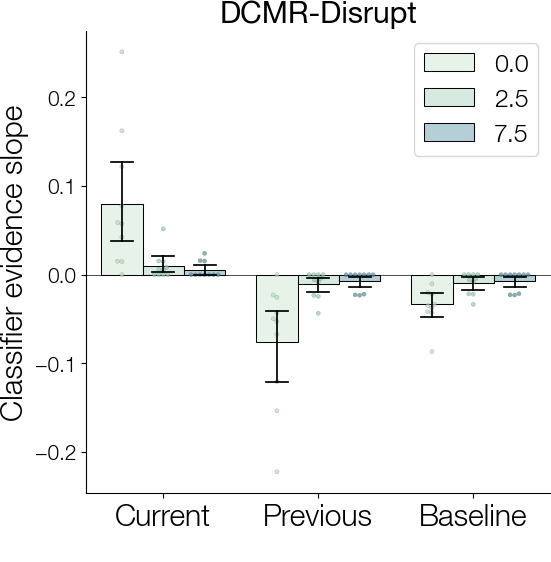

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
sb.plot_swarm_bar(sl, x='category', y='slope', hue='Distraction (s)', dodge=True, ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('DCMR-Disrupt')
fig.savefig(fig_dir / 'context_evidence_slope_swarm.pdf')

/var/folders/46/7_qmfr6s4ql7l4rb8dkwg_m00000gr/T/ipykernel_89116/2748495062.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


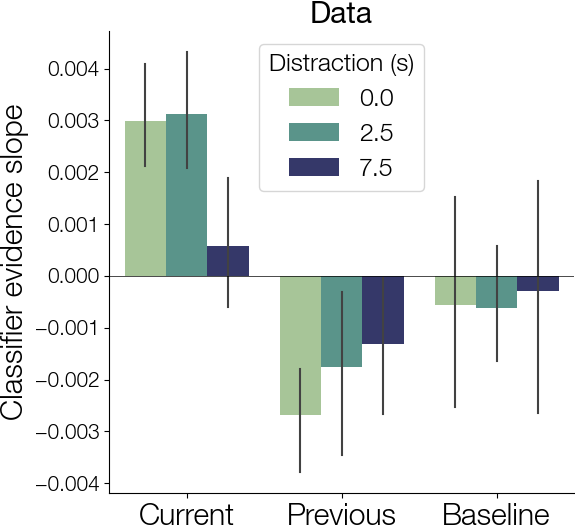

In [10]:
slopes = pd.read_csv(res_dir / 'slopes.csv')
slopes['subject'] = np.repeat(data['subject'].unique(), 9)
slopes['Distraction (s)'] = slopes['condition'].replace({'ifr': "0", 'cd1': "2.5", 'cd2': "7.5"}).astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(slopes, x='category', y='slope', hue='Distraction (s)', palette='crest', ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('Data')
fig.savefig(fig_dir / 'eeg_evidence_slope.pdf')

/var/folders/46/7_qmfr6s4ql7l4rb8dkwg_m00000gr/T/ipykernel_89116/3749589577.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


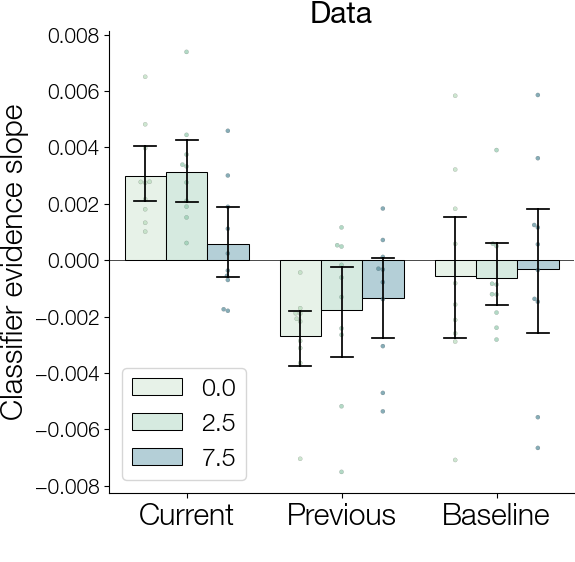

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
sb.plot_swarm_bar(slopes, x='category', y='slope', hue='Distraction (s)', dodge=True, ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('Data')
fig.savefig(fig_dir / 'eeg_evidence_slope_swarm.pdf')

In [12]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 9.2.0

cymr      : 0.13.0
seaborn   : 0.13.2
numpy     : 2.1.3
swarmbar  : 0.1.0
pingouin  : 0.5.5
psifr     : 0.10.1
matplotlib: 3.10.3
dcmr      : 1.0.0a0
pandas    : 2.2.3

